Let's do an exercise connecting the previous domains. We will:

* Get the data from the MNIST digit classification challenge
* Reduce the dimensionality of the images by using the t-SNE technique
* Select a feature map (quantum FM) of our liking
* And build a classifier with it (QSVC in this case)

In [1]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.kernel.ml.qsvc import QSVC
from squlearn.kernel.matrix import ProjectedQuantumKernel

In [2]:
X, y = load_digits(return_X_y=True)

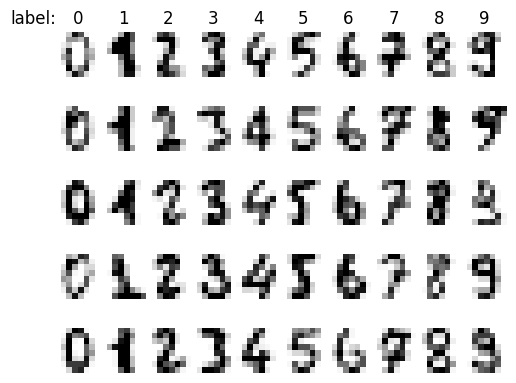

In [3]:
from visualize import plot_dataset

plot_dataset(X, y, rows=5)

In [4]:
X_tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=40).fit_transform(X)

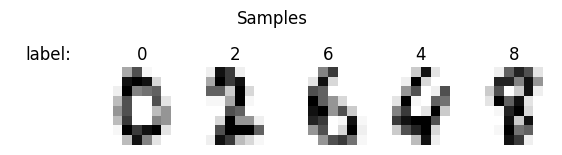

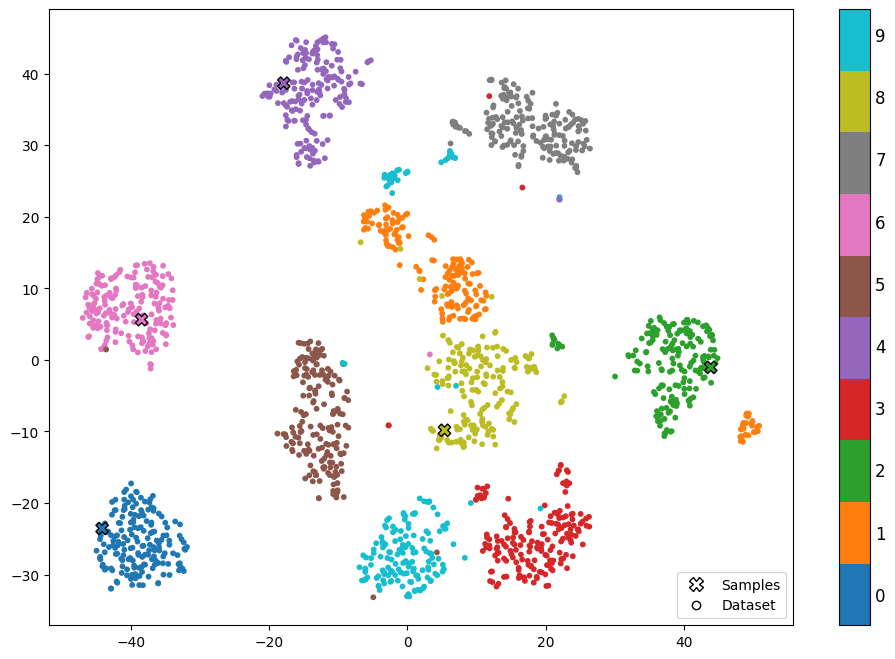

In [7]:
from visualize import plot_numbers, plot_data_in_feature_space

rows = np.random.choice(np.arange(1000, X.shape[0]), 5, replace=False)
plot_numbers(X[rows, :], y[rows], title="label:")

plot_data_in_feature_space(X_tsne, y, highlight_rows=rows)

In [8]:
n_samples = 1000

X_train, X_test, y_train, y_test = train_test_split(
    X_tsne[:n_samples, :],
    y[:n_samples],
    test_size=0.33,
    random_state=42,
)

In [9]:
scaler = MinMaxScaler((-0.9, 0.9))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

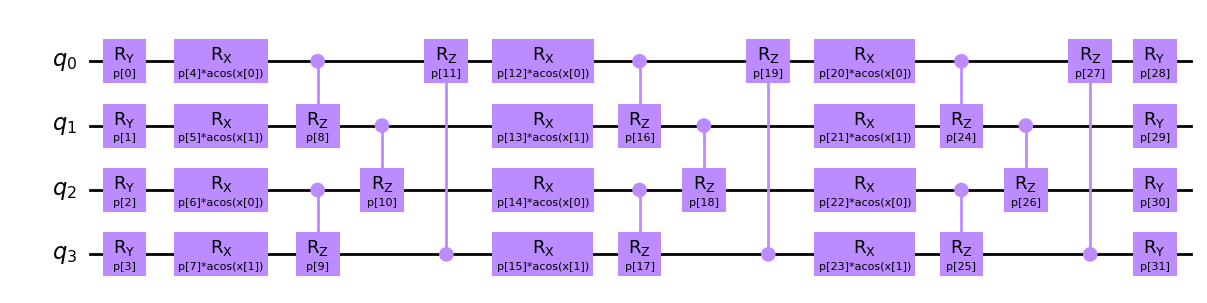

In [11]:
encoding_circuit = ChebyshevPQC(num_qubits=4, num_features=2, num_layers=3)
encoding_circuit.draw(output="mpl", style="clifford")

In [12]:
kernel = ProjectedQuantumKernel(
    encoding_circuit=encoding_circuit,
    executor=Executor("statevector_simulator"),
    measurement="XYZ",
    outer_kernel="gaussian",
    initial_parameters=np.random.rand(encoding_circuit.num_parameters),
    gamma=0.5,
)

In [13]:
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=False,
     quantum_kernel=<squlearn.kernel.matrix.projected_quantum_kernel.ProjectedQuantumKernel object at 0x7f396b56a440>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [14]:
predictions = qsvc.predict(X_train)
print(f"Train accuracy score {accuracy_score(y_train, predictions)}")
predictions = qsvc.predict(X_test)
print(f"Test accuracy score {accuracy_score(y_test, predictions)}")

Train accuracy score 0.9746268656716418
Test accuracy score 0.9787878787878788


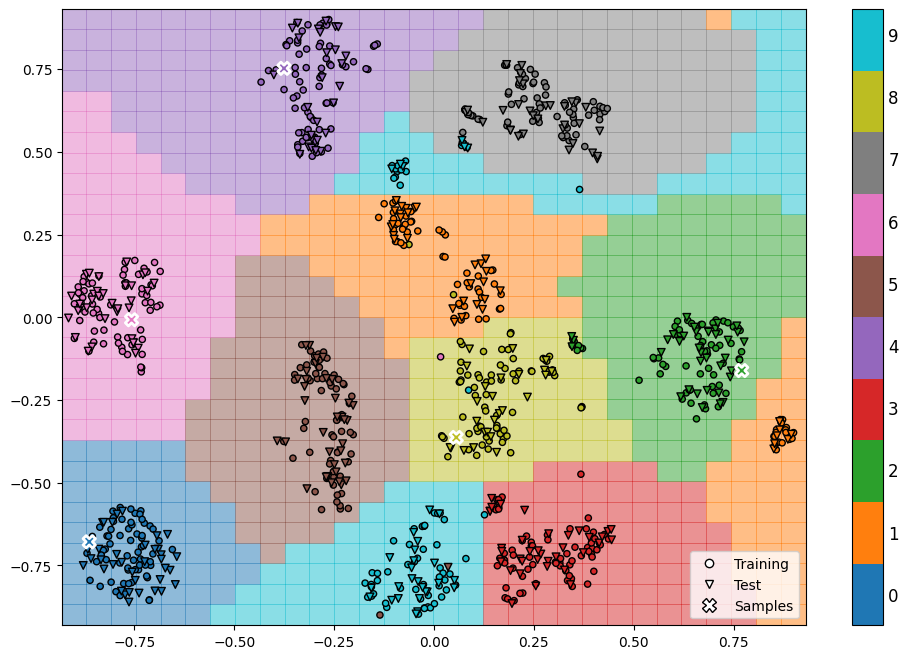

In [15]:
from visualize import plot_results

plot_results(
    clf=qsvc,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_highlight=scaler.transform(X_tsne[rows]),
    y_highlight=y[rows],
    X_range=[(-0.9, 0.9), (-0.9, 0.9)],
    resolution=30,
)

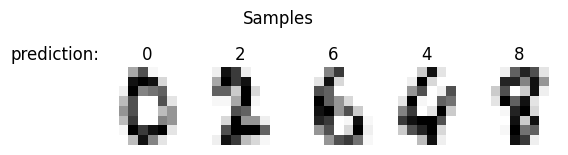

In [16]:
y_pred = qsvc.predict(scaler.transform(X_tsne[rows, :]))

plot_numbers(X[rows, :], y_pred, title="prediction:")